# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions import cosmic_val
from functions.graph_tools import *
from models.aenmf import *
from functions import data_handling as dh
import torch.optim as optim
import torch.nn as nn

np.random.seed(2)
torch.manual_seed(2)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed\Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
LATENT_DIM = 4
TOLERANCE = 1e-10
MAX_ITERATIONS = 100_000_000

In [6]:
losses_train = []
losses_test = []
signatures = []
iterations = 30

for i in tqdm(range(iterations)):
    # Train-test split (here it makes sense, we are working with AE)
    train, test = train_test_split(data.T, test_size = 0.2)

    # Initializing AENMF model
    aenmf_model = aenmf(input_dim = train.shape[1],
                              latent_dim = LATENT_DIM)
    

    # Training AENMF
    aenmf_mod,training_loss_aenmf, signatures_aenmf, exposures_aenmf = train_aenmf( 
                                                model = aenmf_model,
                                                training_data = train,
                                                optimizer = optim.Adam(aenmf_model.parameters(), lr=1e-3),
                                                tol = TOLERANCE,
                                                relative_tol = False,
                                                max_iter = MAX_ITERATIONS)
    
    # Check that test.shape[1] == train.shape[1]

    if(test.shape[1] != train.shape[1]):
        raise ValueError("Test shape is different from train shape. Check the code.")


    test_model = aenmf(input_dim = test.shape[1],
                              latent_dim = LATENT_DIM)
    
    print("Signature shape:", signatures_aenmf.shape)
    print("Test input dimension:", test.shape[1])


    
    test_model.load_custom_weights(signature = signatures_aenmf)
    test_model.freeze_encoder()

    _, test_loss, _, _ = train_aenmf(model = test_model,
                                    training_data = test,
                                    optimizer = optim.Adam(test_model.parameters(), lr=1e-3),
                                    tol = TOLERANCE,
                                    relative_tol = False,
                                    max_iter = MAX_ITERATIONS)


    
    # Calculating signatures and exposures for NMF
    epsilon = 1e-8
    diagonals_aenmf = signatures_aenmf.sum(axis=0)
    signatures_aenmf = (signatures_aenmf) @ np.diag(1 / (diagonals_aenmf + epsilon))
    # signatures_aenmf = (signatures_aenmf) @ np.diag(1 / diagonals_aenmf)

    losses_test.append(test_loss[-1])
    losses_train.append(training_loss_aenmf[-1])
    signatures.append(signatures_aenmf)



  0%|          | 0/30 [00:00<?, ?it/s]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


  3%|▎         | 1/30 [00:28<13:50, 28.64s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


  7%|▋         | 2/30 [00:47<10:38, 22.82s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 10%|█         | 3/30 [01:03<08:53, 19.76s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 13%|█▎        | 4/30 [01:26<09:08, 21.10s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 17%|█▋        | 5/30 [01:50<09:13, 22.12s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 20%|██        | 6/30 [02:11<08:37, 21.57s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 23%|██▎       | 7/30 [02:30<08:01, 20.92s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 27%|██▋       | 8/30 [03:08<09:35, 26.16s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 30%|███       | 9/30 [03:32<08:57, 25.59s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 33%|███▎      | 10/30 [03:48<07:33, 22.68s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 37%|███▋      | 11/30 [04:11<07:13, 22.82s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 40%|████      | 12/30 [04:40<07:25, 24.77s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 43%|████▎     | 13/30 [05:02<06:46, 23.89s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 47%|████▋     | 14/30 [05:24<06:10, 23.18s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 50%|█████     | 15/30 [05:45<05:39, 22.66s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 53%|█████▎    | 16/30 [06:08<05:16, 22.59s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 57%|█████▋    | 17/30 [06:34<05:09, 23.82s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 60%|██████    | 18/30 [07:00<04:51, 24.32s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 63%|██████▎   | 19/30 [07:25<04:31, 24.66s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 67%|██████▋   | 20/30 [07:45<03:52, 23.26s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 70%|███████   | 21/30 [08:07<03:24, 22.70s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 73%|███████▎  | 22/30 [08:23<02:45, 20.70s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 77%|███████▋  | 23/30 [08:43<02:24, 20.62s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 80%|████████  | 24/30 [08:59<01:55, 19.25s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 83%|████████▎ | 25/30 [09:23<01:42, 20.47s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 87%|████████▋ | 26/30 [09:42<01:20, 20.25s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 90%|█████████ | 27/30 [10:14<01:10, 23.63s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 93%|█████████▎| 28/30 [10:40<00:48, 24.37s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 97%|█████████▋| 29/30 [10:57<00:22, 22.24s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


100%|██████████| 30/30 [11:24<00:00, 22.83s/it]


In [7]:
print("Losses train: ", np.mean(losses_train))
print("Losses test: ", np.mean(losses_test))

Losses train:  18627.03642578125
Losses test:  16422.886279296876


In [8]:
all_signatures = np.hstack(signatures)

In [9]:
print(all_signatures.shape)

(96, 120)


In [10]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [11]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [12]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0    SBS5      0.598674
1            1  SBS10a      0.923463
2            2   SBS52      0.784138
3            3   SBS44      0.823271

Mean similarity of the matched signatures:  0.7823864352723399


In [13]:
all_matches = cosmic_val.compute_all_matches(all_signatures, cosmic, n_runs = 4)

In [14]:
all_matches

,True_0,Similarity_0,True_1,Similarity_1,True_2,Similarity_2,True_3,Similarity_3,True_4,Similarity_4,...,True_25,Similarity_25,True_26,Similarity_26,True_27,Similarity_27,True_28,Similarity_28,True_29,Similarity_29
0,SBS44,0.842516,SBS10a,0.928963,SBS26,0.793862,SBS52,0.788984,SBS44,0.784334,...,SBS5,0.598674,SBS52,0.789626,SBS10a,0.923616,SBS1,0.925951,SBS10a,0.922655
1,SBS52,0.794005,SBS6,0.931496,SBS6,0.940547,SBS5,0.602753,SBS5,0.590095,...,SBS52,0.784138,SBS10a,0.923463,SBS5,0.601428,SBS3,0.870014,SBS5,0.603376
2,SBS15,0.626148,SBS12,0.826784,SBS13,0.753287,SBS44,0.836025,SBS52,0.788317,...,SBS10a,0.923973,SBS5,0.600791,SBS52,0.792298,SBS44,0.830660,SBS52,0.788974
3,SBS10a,0.923834,SBS13,0.775524,SBS10a,0.928721,SBS10a,0.922876,SBS10a,0.923348,...,SBS44,0.825598,SBS44,0.821006,SBS44,0.831985,SBS13,0.776613,SBS44,0.837779


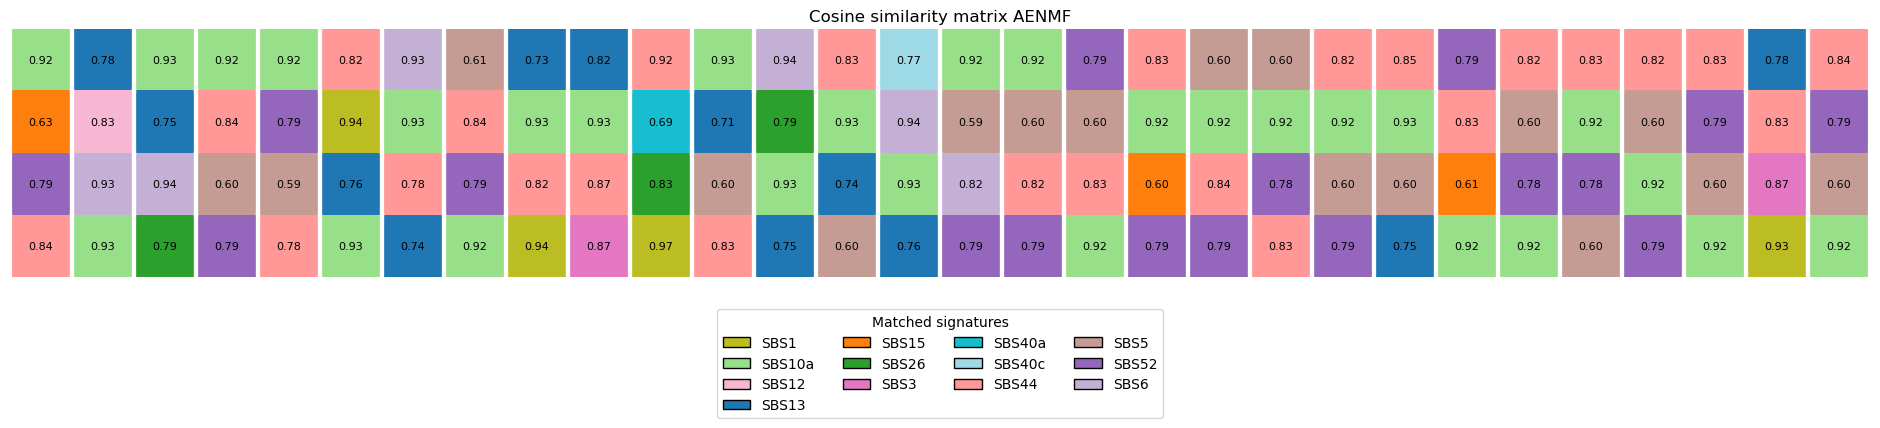

In [15]:
plot_cosine_similarity_matrix(all_matches, title = "Cosine similarity matrix AENMF", figsize=(24, 12), legend_colums=4, palette='tab20')

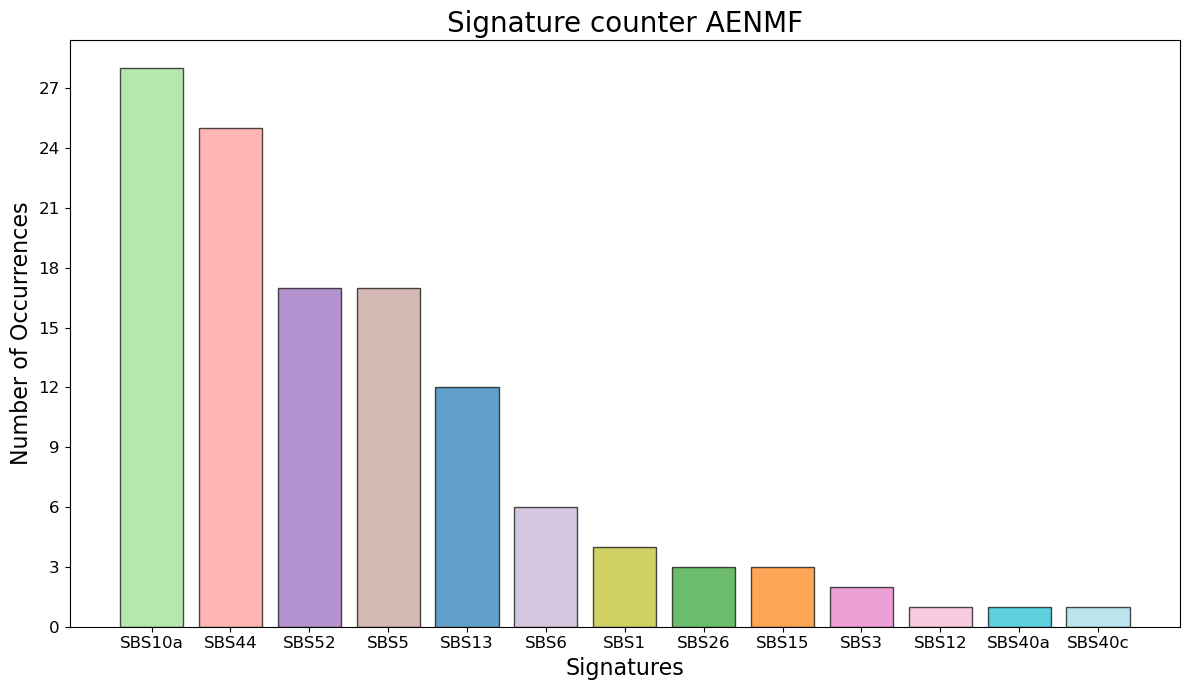

In [16]:
plot_signature_frequency(all_matches, title = "Signature counter AENMF", figsize=(12,7), color='tab20')

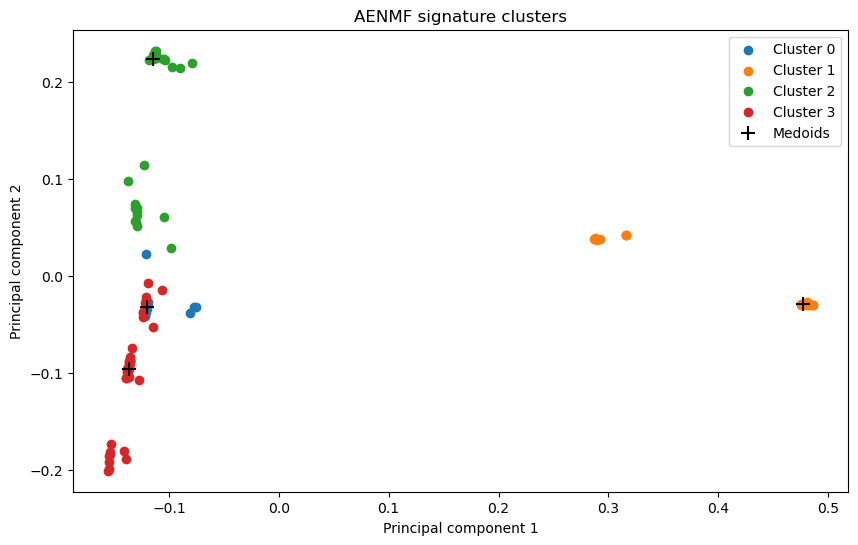

In [17]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "AENMF signature clusters")

In [18]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

In [19]:
df_consensus

,0,1,2,3
Type,,,,
A[C>A]A,0.000000,0.000000,0.007719,0.005237
A[C>A]C,0.000658,0.000000,0.011822,0.006432
A[C>A]G,0.000000,0.000000,0.001629,0.000449
A[C>A]T,0.017698,0.000000,0.052241,0.002021
A[C>G]A,0.000533,0.000000,0.001430,0.005510
...,...,...,...,...
T[T>C]T,0.000000,0.013144,0.005595,0.056462
T[T>G]A,0.000000,0.012677,0.045847,0.000000
T[T>G]C,0.011453,0.007652,0.011611,0.000000


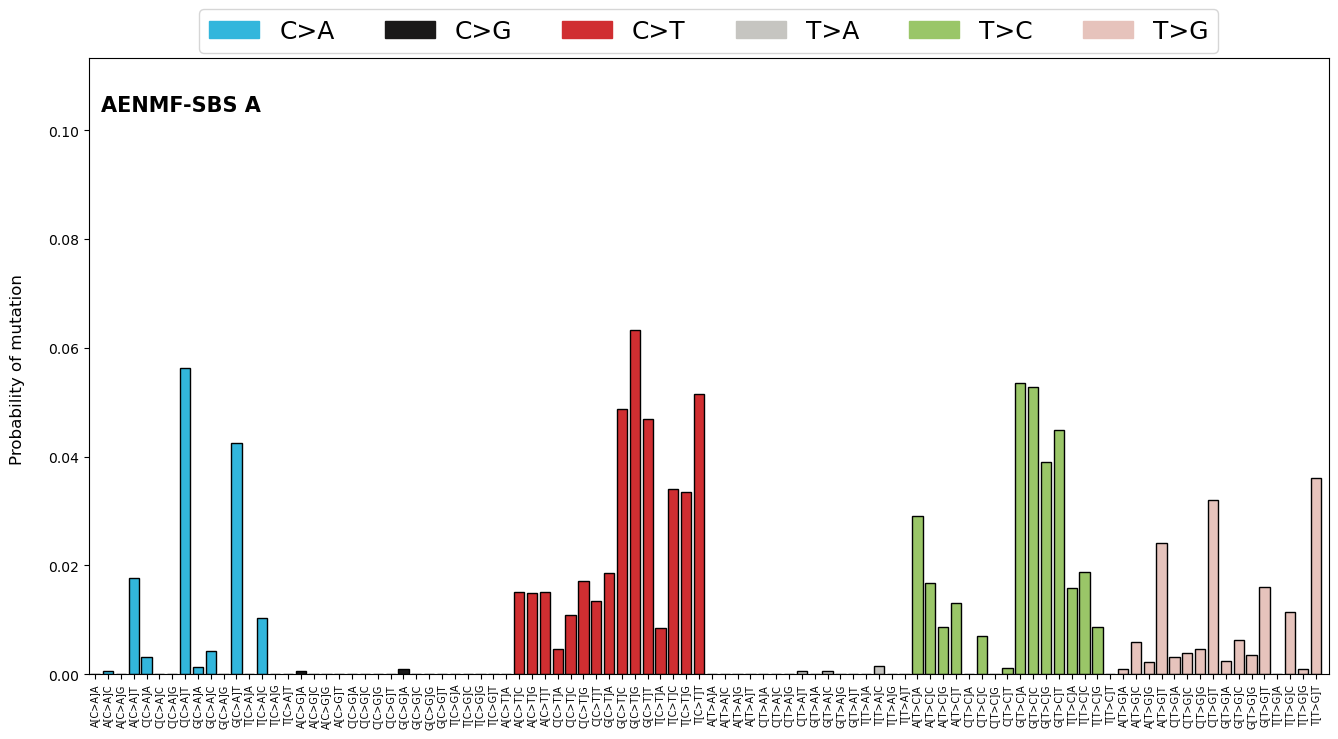

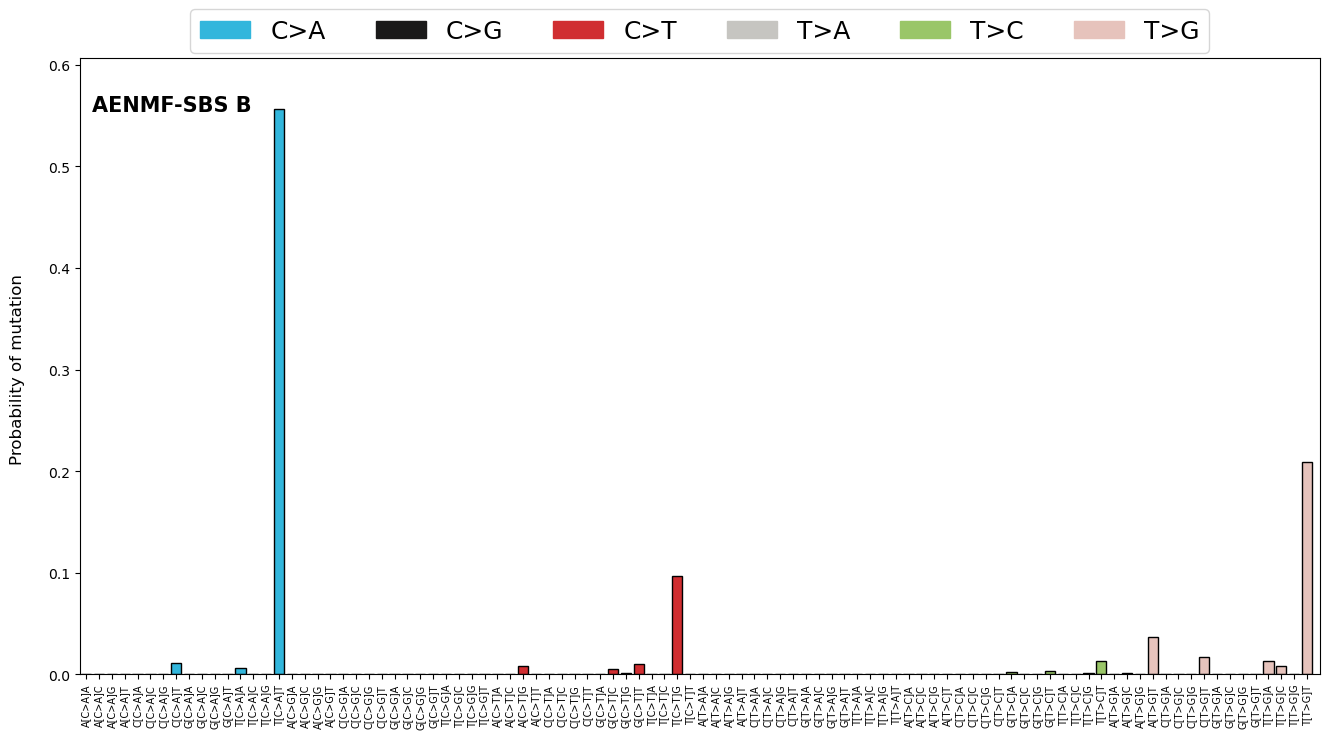

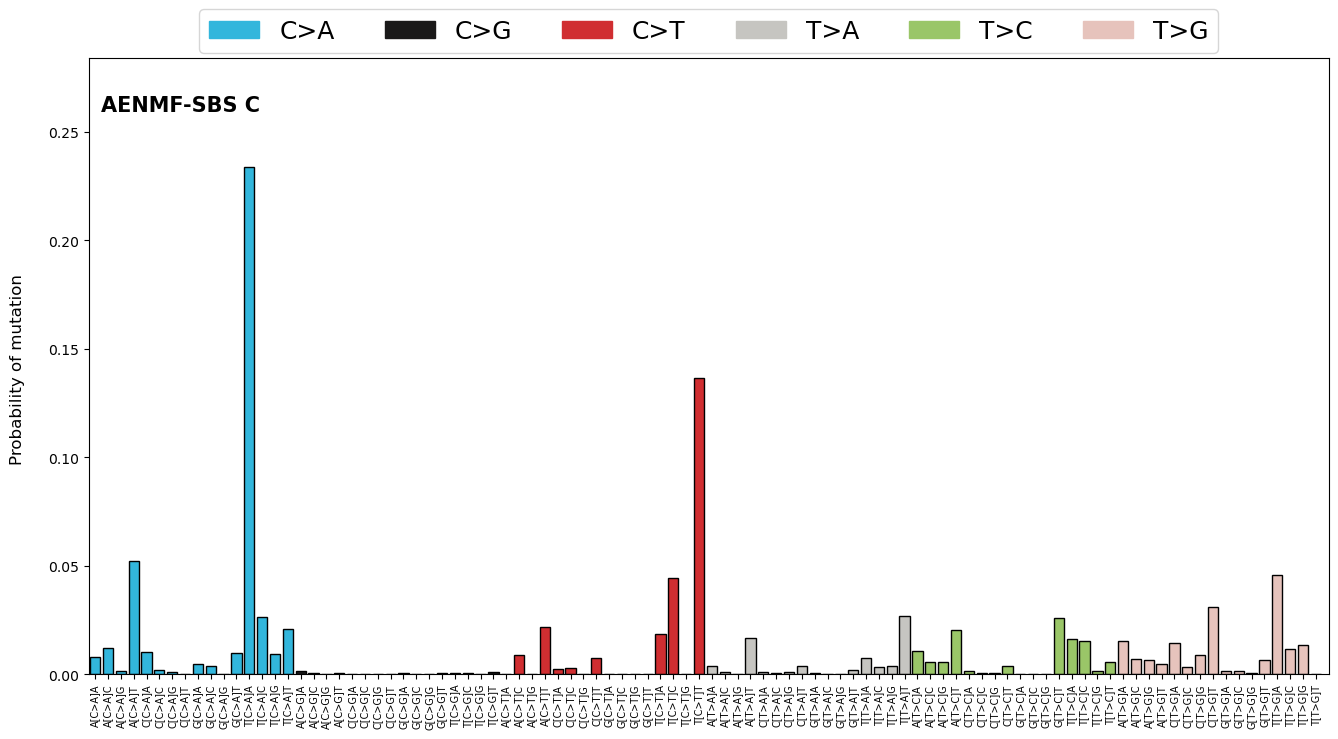

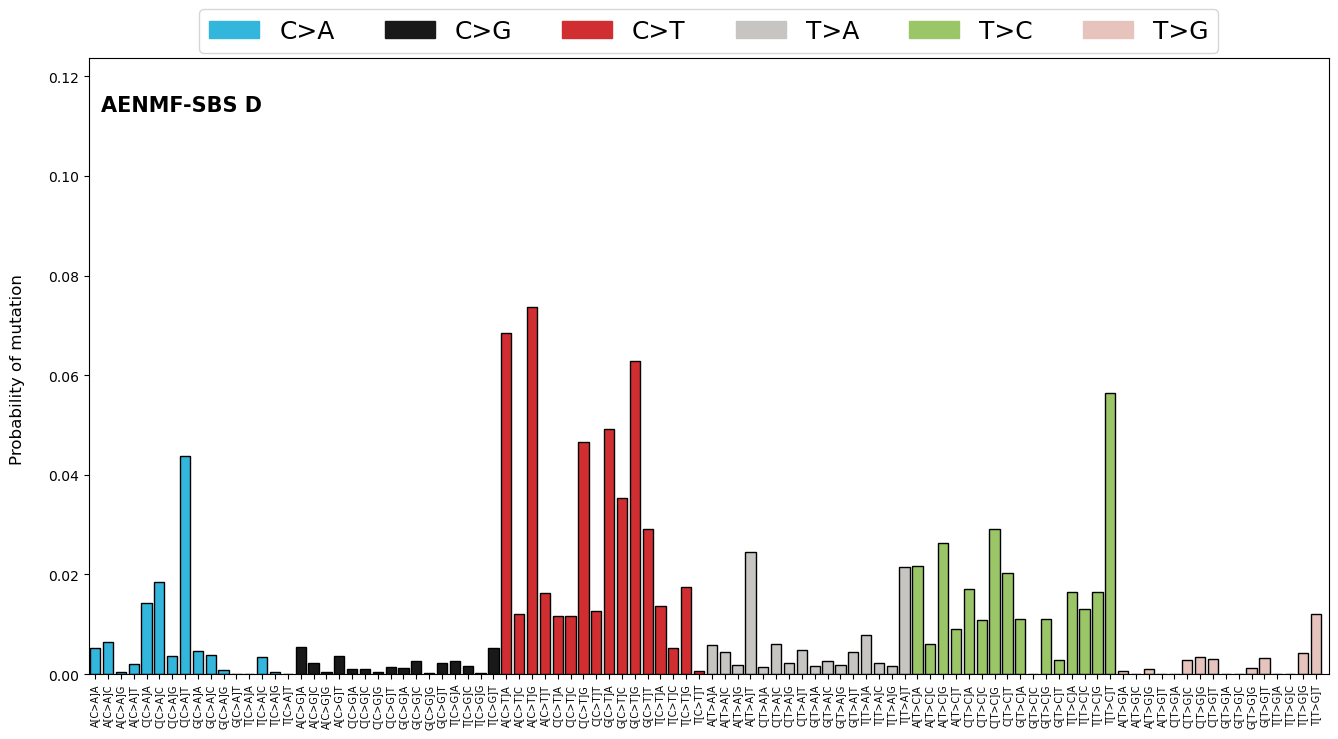

In [20]:
plot_signature(df_consensus, "AENMF")